# Project 1

### Data Gathering

Collect the data from 2018 FIFA World Cup web page (http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results) using web scrapping technique.

In [534]:
#import libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [535]:
#read content from http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results page
html = urlopen("http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results")
res = BeautifulSoup(html.read(),"html5lib");

#find all matches
matches = res.findAll("tr", {"itemtype": "https://schema.org/SportsEvent"})

#create list variables to store web content
teams = list()
teams_list = list()
goals = list()
goals_list = list()

#find all teams
for match in matches:
    teams = match.findAll("p", {"itemprop":"performer"})
    for item in teams:
            team = item.get_text()
            teams_list.append(team)

print(teams_list)

#find goals
for match in matches:
    goals = match.findAll("p", {"itemprop":"startDate"})
    for item in goals:
            goal = item.get_text()
            goals_list.append(goal)

print(goals_list)

['RUSSIA', 'SAUDI ARABIA', 'EGYPT', 'URUGUAY', 'MOROCCO', 'IR IRAN', 'PORTUGAL', 'SPAIN', 'FRANCE', 'AUSTRALIA', 'ARGENTINA', 'ICELAND', 'PERU', 'DENMARK', 'CROATIA', 'NIGERIA', 'COSTA RICA', 'SERBIA', 'GERMANY', 'MEXICO', 'BRAZIL', 'SWITZERLAND', 'SWEDEN', 'KOREA REPUBLIC', 'BELGIUM', 'PANAMA', 'TUNISIA', 'ENGLAND', 'COLOMBIA', 'JAPAN', 'POLAND', 'SENEGAL', 'RUSSIA', 'EGYPT', 'PORTUGAL', 'MOROCCO', 'URUGUAY', 'SAUDI ARABIA', 'IR IRAN', 'SPAIN', 'DENMARK', 'AUSTRALIA', 'FRANCE', 'PERU', 'ARGENTINA', 'CROATIA', 'BRAZIL', 'COSTA RICA', 'NIGERIA', 'ICELAND', 'SERBIA', 'SWITZERLAND', 'BELGIUM', 'TUNISIA', 'KOREA REPUBLIC', 'MEXICO', 'GERMANY', 'SWEDEN', 'ENGLAND', 'PANAMA', 'JAPAN', 'SENEGAL', 'POLAND', 'COLOMBIA', 'URUGUAY', 'RUSSIA', 'SAUDI ARABIA', 'EGYPT', 'IR IRAN', 'PORTUGAL', 'SPAIN', 'MOROCCO', 'DENMARK', 'FRANCE', 'AUSTRALIA', 'PERU', 'NIGERIA', 'ARGENTINA', 'ICELAND', 'CROATIA', 'MEXICO', 'SWEDEN', 'KOREA REPUBLIC', 'GERMANY', 'SERBIA', 'BRAZIL', 'SWITZERLAND\xa0 \xa0 \xa0', 'COS

### Data Cleaning

In [536]:
#create matches DataFrame
matches = pd.DataFrame()

#create team 1 variable
matches['team 1'] = teams_list[::2]
#create team 2 variable
matches['team 2'] = teams_list[1::2]

#create scores variable
matches['scores'] = goals_list

matches.tail()

#add missing result
matches['scores'][len(matches)-1] = '2-4'
matches.head()

,team 1,team 2,scores
0,RUSSIA,SAUDI ARABIA,5-0
1,EGYPT,URUGUAY,0-1
2,MOROCCO,IR IRAN,0-1
3,PORTUGAL,SPAIN,3-3
4,FRANCE,AUSTRALIA,2-1


Split scores column to two columns.

In [537]:
matches['team1_score'] = matches['scores'].str.split('-',expand=True)[0]
matches['team2_score'] = matches['scores'].str.split('-',expand=True)[1]
matches.tail()

,team 1,team 2,scores,team1_score,team2_score
59,SWEDEN,ENGLAND,0-2,0,2
60,FRANCE,BELGIUM,1-0,1,0
61,CROATIA,ENGLAND,2-1,2,1
62,BELGIUM,ENGLAND,2-0,2,0
63,FRANCE,CROATIA,2-4,2,4


Convert penalties to goals.

In [538]:
#read integer between parentheses
for i in range(0,len(matches['team1_score'])-1):
    mo = re.search(r'\((.*)\)', matches['team1_score'][i])
    if mo:
        matches['team1_score'][i] = mo.group(1)

#read integer between parentheses
for i in range(0,len(matches['team2_score'])-1):
    mo = re.search(r'\((.*)\)', matches['team2_score'][i])
    if mo:
        matches['team2_score'][i] = mo.group(1)        

matches.tail()        

,team 1,team 2,scores,team1_score,team2_score
59,SWEDEN,ENGLAND,0-2,0,2
60,FRANCE,BELGIUM,1-0,1,0
61,CROATIA,ENGLAND,2-1,2,1
62,BELGIUM,ENGLAND,2-0,2,0
63,FRANCE,CROATIA,2-4,2,4


In [539]:
#convert goals variable to numeric type
matches['team1_score'] = matches['team1_score'].astype(float)
matches['team2_score'] = matches['team2_score'].astype(float)

#create two new columns - 'winneng team' and 'losing team'
matches['winneng_team'] = np.where(matches['team1_score']>=matches['team2_score'], matches['team 1'],matches['team 2'])
matches['losing_team'] = np.where(matches['team1_score']<matches['team2_score'], matches['team 1'],matches['team 2'])

matches.head()

,team 1,team 2,scores,team1_score,team2_score,winneng_team,losing_team
0,RUSSIA,SAUDI ARABIA,5-0,5.0,0.0,RUSSIA,SAUDI ARABIA
1,EGYPT,URUGUAY,0-1,0.0,1.0,URUGUAY,EGYPT
2,MOROCCO,IR IRAN,0-1,0.0,1.0,IR IRAN,MOROCCO
3,PORTUGAL,SPAIN,3-3,3.0,3.0,PORTUGAL,SPAIN
4,FRANCE,AUSTRALIA,2-1,2.0,1.0,FRANCE,AUSTRALIA


In [540]:
#write data to csv file
match_results = matches[['winneng_team','losing_team']].copy()
match_results.head()
match_results.to_csv('match_results1.csv',index=False)

Draw graph.

In [542]:
#create empty graph
G = nx.DiGraph()

#add edges
edges = list()
for index, row in matches.iterrows():
    edge = (row['winneng_team'], row['losing_team'])
    edges.append(edge)

G.add_edges_from(edges)

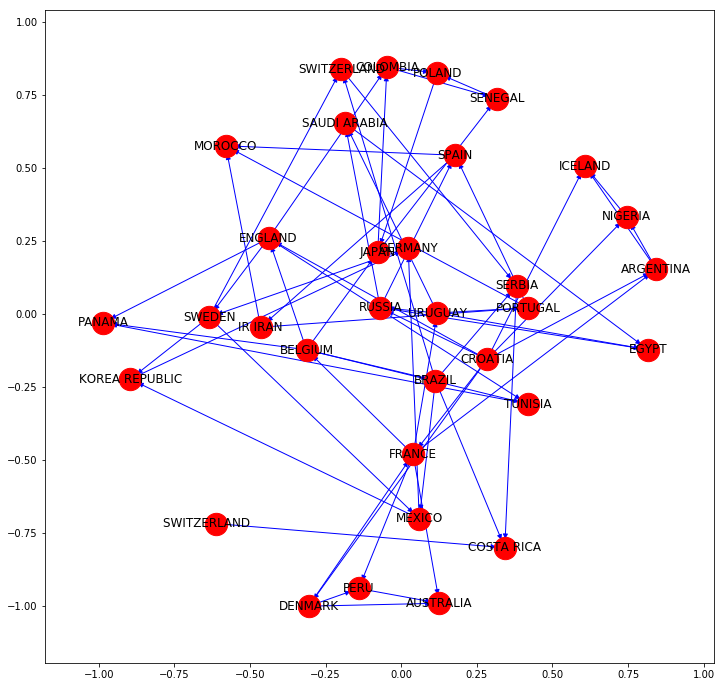

<Figure size 720x720 with 0 Axes>

In [543]:
#draw graph
pos = nx.spring_layout(G,k=1)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'r', node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

#increase size of graph
plt.figure(figsize=(10,10))


plt.show()
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
fig_size = plt.rcParams["figure.figsize"]
 


Calculate degree centrality for each node (team). Degree centrality identifies how manuy connections each node has to other nodes within the network. Since the FIFA network is directed degree centrality mesuares by in-degree or out-degree. Let's calculate out-degree that specifies the number of out-going links or the number of successor nodes.

In [544]:
#calculate degree_centrality 
matches.groupby('winneng_team').size()

winneng_team
ARGENTINA           2
BELGIUM             6
BRAZIL              4
COLOMBIA            2
CROATIA             7
DENMARK             3
ENGLAND             4
FRANCE              5
GERMANY             1
IR IRAN             2
JAPAN               2
KOREA REPUBLIC      1
MEXICO              2
NIGERIA             1
PERU                1
POLAND              1
PORTUGAL            2
RUSSIA              3
SAUDI ARABIA        1
SENEGAL             1
SERBIA              1
SPAIN               2
SWEDEN              3
SWITZERLAND         1
SWITZERLAND         1
TUNISIA             1
URUGUAY             4
dtype: int64

Calculate EigenCentrality. EigenCentrality measures a node’s influence based on the number of links it has to other nodes within the network.

In [545]:
centrality = nx.eigenvector_centrality(G)
sorted((v, '{:0.2f}'.format(c)) for v, c in centrality.items())

[('ARGENTINA', '0.00'),
 ('AUSTRALIA', '0.00'),
 ('BELGIUM', '0.00'),
 ('BRAZIL', '0.00'),
 ('COLOMBIA', '0.22'),
 ('COSTA RICA', '0.11'),
 ('CROATIA', '0.00'),
 ('DENMARK', '0.00'),
 ('EGYPT', '0.00'),
 ('ENGLAND', '0.00'),
 ('FRANCE', '0.00'),
 ('GERMANY', '0.43'),
 ('ICELAND', '0.00'),
 ('IR IRAN', '0.00'),
 ('JAPAN', '0.30'),
 ('KOREA REPUBLIC', '0.38'),
 ('MEXICO', '0.22'),
 ('MOROCCO', '0.00'),
 ('NIGERIA', '0.00'),
 ('PANAMA', '0.00'),
 ('PERU', '0.00'),
 ('POLAND', '0.42'),
 ('PORTUGAL', '0.00'),
 ('RUSSIA', '0.00'),
 ('SAUDI ARABIA', '0.00'),
 ('SENEGAL', '0.37'),
 ('SERBIA', '0.16'),
 ('SPAIN', '0.00'),
 ('SWEDEN', '0.31'),
 ('SWITZERLAND', '0.22'),
 ('SWITZERLAND\xa0 \xa0 \xa0', '0.00'),
 ('TUNISIA', '0.00'),
 ('URUGUAY', '0.00')]